In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as seaborn

path = kagglehub.dataset_download("rohitudageri/credit-card-details")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\rohitudageri\credit-card-details\versions\1


In [2]:
df1 = pd.read_csv(path+'\\Credit_card.csv')
df2 = pd.read_csv(path+'\\Credit_card_label.csv')

In [3]:
df3 = df1.merge(df2[['Ind_ID', 'label']], on='Ind_ID', how='left')

df3 = df3.drop(['Ind_ID', 'Birthday_count','Employed_days', 'Mobile_phone', 'Work_Phone', 
                'Phone', 'Type_Occupation', 'EDUCATION', 'Marital_status', 'EMAIL_ID', 'Housing_type'], axis=1)


df3['GENDER'] = df3['GENDER'].map({'M': 1, 'F': 0})
df3 = df3.dropna(subset=['GENDER'])
df3['Car_Owner'] = df3['Car_Owner'].map({'Y': 1, 'N': 0})
df3['Propert_Owner'] = df3['Propert_Owner'].map({'Y': 1, 'N': 0})
df3['Annual_income'] = df3['Annual_income'].fillna(0)
df3['Type_Income_Pensioner'] = df3['Type_Income'].map({'Pensioner': 1}).fillna(0)
df3 = df3.drop('Type_Income', axis=1)

df3

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Family_Members,label,Type_Income_Pensioner
0,1.0,1,1,0,180000.0,2,1,1.0
1,0.0,1,0,0,315000.0,2,1,0.0
2,0.0,1,0,0,315000.0,2,1,0.0
3,0.0,1,0,0,0.0,2,1,0.0
4,0.0,1,0,0,315000.0,2,1,0.0
...,...,...,...,...,...,...,...,...
1543,0.0,0,1,0,0.0,2,0,0.0
1544,0.0,0,0,0,225000.0,1,0,0.0
1545,1.0,1,1,2,180000.0,4,0,0.0
1546,1.0,1,0,0,270000.0,2,0,0.0


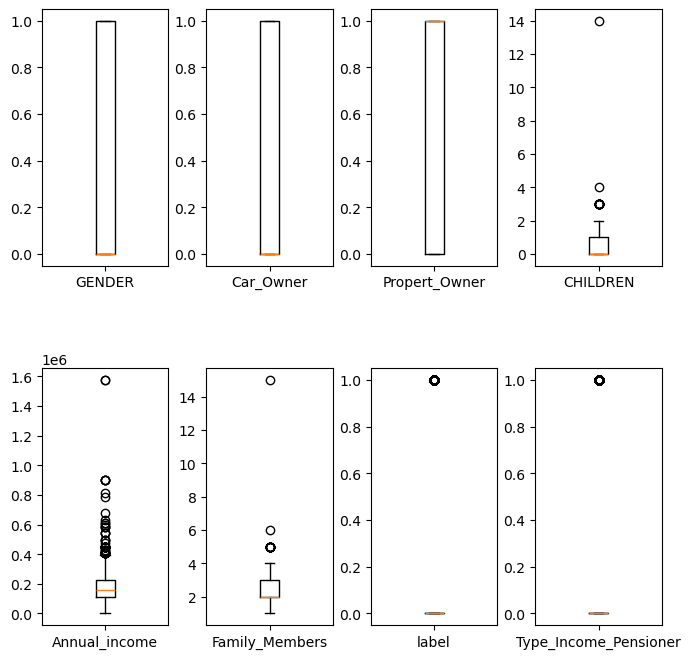

In [4]:
labels = df3.columns.to_list()

fig, ax = plt.subplots(2, 4, figsize=(8, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.3) 

for i in range(8):
    ax[i // 4, i % 4].boxplot(df3.loc[:,[labels[i]]], tick_labels = [labels[i]])

plt.show()

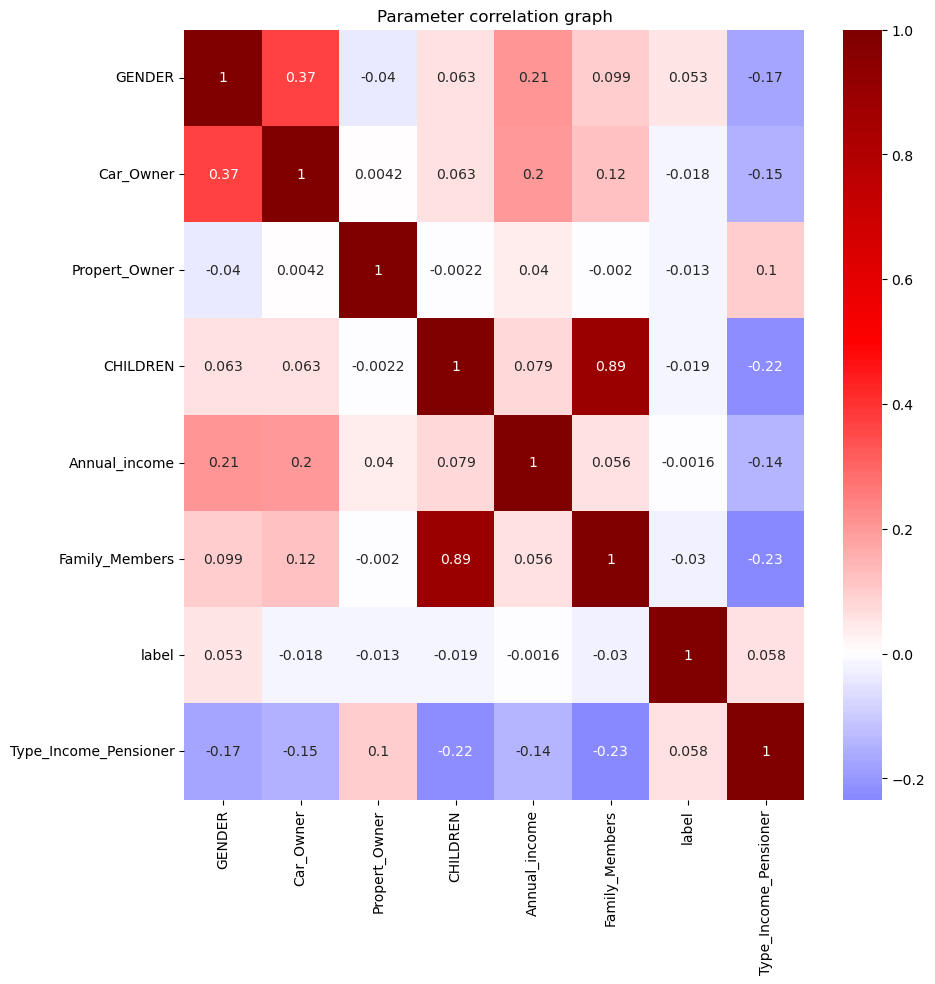

In [5]:
plt.figure(figsize=(10, 10))
seaborn.heatmap(df3.corr(), annot=True, cmap='seismic', center=0)
plt.title('Parameter correlation graph')
plt.show()

In [6]:
list_col = df3.columns.to_list()
list_col

['GENDER',
 'Car_Owner',
 'Propert_Owner',
 'CHILDREN',
 'Annual_income',
 'Family_Members',
 'label',
 'Type_Income_Pensioner']

In [7]:
from sklearn.model_selection import train_test_split

x = df3.loc[:,['GENDER', 'Car_Owner', 'Propert_Owner', 'CHILDREN', 'Annual_income', 'Family_Members', 'Type_Income_Pensioner']].to_numpy()
y = df3.loc[:,['label']].to_numpy().flatten()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [8]:
from collections import Counter

Counter(y_train)

Counter({np.int64(0): 1234, np.int64(1): 152})

In [9]:
#дублирование для борьбы с дисбалансом
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)

In [10]:
Counter(y_train_ros)

Counter({np.int64(0): 1234, np.int64(1): 1234})

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf1 = DecisionTreeClassifier(random_state = 0, max_depth = 5, min_samples_leaf = 75)
clf2 = DecisionTreeClassifier(random_state = 0, max_depth = 35, min_samples_leaf = 1)
clf3 = DecisionTreeClassifier(random_state = 0, max_depth = 5, min_samples_leaf = 75)

print('k-fold метрика без дисбаланса (5 / 75)', cross_val_score(clf1, x_train_ros, y_train_ros, cv=5))
print('k-fold метрика без дисбаланса (35 / 1)', cross_val_score(clf2, x_train_ros, y_train_ros, cv=5))
print('k-fold метрика с дисбалансом (5 / 75)', cross_val_score(clf3, x_train, y_train, cv=5))

k-fold метрика без дисбаланса (5 / 75) [0.61133603 0.61133603 0.60323887 0.57403651 0.5801217 ]
k-fold метрика без дисбаланса (35 / 1) [0.87449393 0.86639676 0.86437247 0.86815416 0.85598377]
k-fold метрика с дисбалансом (5 / 75) [0.88848921 0.89169675 0.89169675 0.89169675 0.88808664]


In [12]:
clf1.fit(x_train_ros, y_train_ros)
clf2.fit(x_train_ros, y_train_ros)
clf3.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=75, random_state=0)

In [13]:
print('точность без дисбаланса (5 / 75) для обучающей выборки', clf1.score(x_train_ros, y_train_ros))
print('точность без дисбаланса (5 / 75) для тестовой выборки', clf1.score(x_test, y_test))
print('точность без дисбаланса (35 / 1) для обучающей выборки', clf2.score(x_train_ros, y_train_ros))
print('точность без дисбаланса (35 / 1) для тестовой выборки', clf2.score(x_test, y_test))
print('точность с дисбалансом (5 / 75) для обучающей выборки', clf3.score(x_train, y_train))
print('точность с дисбалансом (5 / 75) для тестовой выборки', clf3.score(x_test, y_test))

точность без дисбаланса (5 / 75) для обучающей выборки 0.6227714748784441
точность без дисбаланса (5 / 75) для тестовой выборки 0.5741935483870968
точность без дисбаланса (35 / 1) для обучающей выборки 0.9141004862236629
точность без дисбаланса (35 / 1) для тестовой выборки 0.7612903225806451
точность с дисбалансом (5 / 75) для обучающей выборки 0.8903318903318903
точность с дисбалансом (5 / 75) для тестовой выборки 0.8838709677419355


[Text(0.7119565217391305, 0.9166666666666666, 'x[4] <= 447750.0\ngini = 0.5\nsamples = 2468\nvalue = [1234, 1234]'),
 Text(0.5108695652173914, 0.75, 'x[6] <= 0.5\ngini = 0.499\nsamples = 2312\nvalue = [1204, 1108]'),
 Text(0.611413043478261, 0.8333333333333333, 'True  '),
 Text(0.2391304347826087, 0.5833333333333334, 'x[0] <= 0.5\ngini = 0.495\nsamples = 1833\nvalue = [1007.0, 826.0]'),
 Text(0.08695652173913043, 0.4166666666666667, 'x[4] <= 72675.0\ngini = 0.48\nsamples = 1030\nvalue = [617, 413]'),
 Text(0.043478260869565216, 0.25, 'gini = 0.478\nsamples = 86\nvalue = [34, 52]'),
 Text(0.13043478260869565, 0.25, 'x[4] <= 120375.0\ngini = 0.472\nsamples = 944\nvalue = [583, 361]'),
 Text(0.08695652173913043, 0.08333333333333333, 'gini = 0.389\nsamples = 204\nvalue = [150, 54]'),
 Text(0.17391304347826086, 0.08333333333333333, 'gini = 0.486\nsamples = 740\nvalue = [433, 307]'),
 Text(0.391304347826087, 0.4166666666666667, 'x[4] <= 132750.0\ngini = 0.5\nsamples = 803\nvalue = [390.0, 41

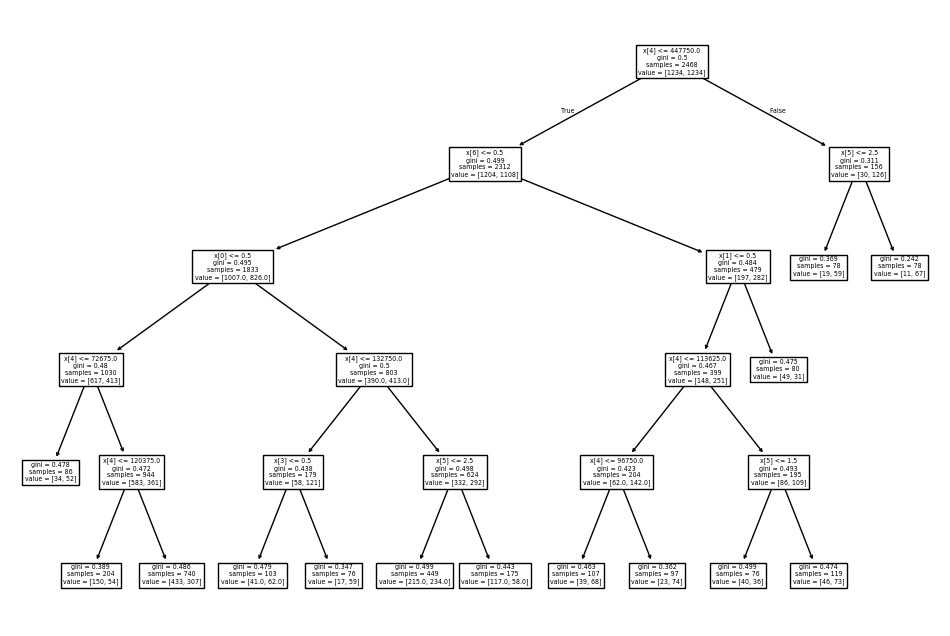

In [14]:
from sklearn import tree
plt.figure(figsize=(12,8))

tree.plot_tree(clf1.fit(x_train_ros, y_train_ros)) 

In [15]:
class DecisionTree:
    def __init__(self, max_depth = 5, min_samples_leaf = 100):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
    
    def gini(self, y):
        counts = Counter(y)
        impurity = 1
        for label in counts:
            prob = counts[label] / len(y)
            impurity -= prob**2
        return impurity
    
    def best_split(self, X, y):
        best_gini = 1000000
        best_feature = None
        best_threshold = None
        
        for feature_idx in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_idx])
            
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = X[:, feature_idx] > threshold
                
                if len(y[left_mask]) < self.min_samples_leaf or len(y[right_mask]) < self.min_samples_leaf:
                    continue
                
                gini_left = self.gini(y[left_mask])
                gini_right = self.gini(y[right_mask])
                total_gini = (len(y[left_mask]) * gini_left + len(y[right_mask]) * gini_right) / len(y)
                
                if total_gini < best_gini:
                    best_gini = total_gini
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def build_tree(self, X, y, depth = 0):

        if (depth >= self.max_depth or len(y) < 2 * self.min_samples_leaf or len(np.unique(y)) == 1):
            return {'prediction': Counter(y).most_common(1)[0][0]}

        feature, threshold = self.best_split(X, y)
        
        if feature is None:
            return {'prediction': Counter(y).most_common(1)[0][0]}
        
        left_mask = X[:, feature] <= threshold
        right_mask = X[:, feature] > threshold
        
        left_subtree = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self.build_tree(X[right_mask], y[right_mask], depth + 1)

        return {'feature': feature,
                'threshold': threshold,
                'left': left_subtree,
                'right': right_subtree}
    
    def fit(self, X, y):
        self.tree = self.build_tree(X, y)
    
    def predict_one(self, x, node):
        if 'prediction' in node:
            return node['prediction']
        
        feature = node['feature']
        threshold = node['threshold']
        
        if x[feature] <= threshold:
            return self.predict_one(x, node['left'])
        else:
            return self.predict_one(x, node['right'])
    
    def predict(self, X):
        return [self.predict_one(x, self.tree) for x in X]

    def print_tree(self, node = None, depth = 0):
        if node is None:
            node = self.tree
        indent = "    " * depth
        if 'prediction' in node:
            print(f"{indent}Предсказание: {node['prediction']}")
        else:
            print(f"{indent}Признак {node['feature']} <= {node['threshold']}")
            self.print_tree(node['left'], depth + 1)
            self.print_tree(node['right'], depth + 1)

In [16]:
tree = DecisionTree(max_depth = 5, min_samples_leaf = 75)
tree.fit(x_train_ros, y_train_ros)

print("Структура дерева:")
tree.print_tree()

Структура дерева:
Признак 4 <= 445500.0
    Признак 6 <= 0.0
        Признак 0 <= 0.0
            Признак 4 <= 72000.0
                Предсказание: 1
                Признак 4 <= 119250.0
                    Предсказание: 0
                    Предсказание: 0
            Признак 4 <= 130500.0
                Признак 3 <= 0.0
                    Предсказание: 1
                    Предсказание: 1
                Признак 5 <= 2.0
                    Предсказание: 1
                    Предсказание: 0
        Признак 1 <= 0.0
            Признак 4 <= 112500.0
                Признак 4 <= 94500.0
                    Предсказание: 1
                    Предсказание: 1
                Признак 5 <= 1.0
                    Предсказание: 0
                    Предсказание: 1
            Предсказание: 0
    Признак 5 <= 2.0
        Предсказание: 1
        Предсказание: 1


In [18]:
predictions = tree.predict(x_test)
for i in range(21, 40):
    print(predictions[i], y_test[i], predictions[i] == y_test[i])

1 0 False
1 0 False
0 0 True
0 0 True
0 0 True
1 0 False
0 0 True
1 0 False
1 0 False
0 0 True
0 0 True
1 0 False
0 0 True
0 1 False
1 0 False
0 0 True
0 0 True
1 0 False
1 0 False
